In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,speech,happy,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.061167,2.701833,[5.9604645e-08 9.2448331e-02 7.0120022e-02 ......,[5.9604645e-08 9.2448264e-02 7.0119813e-02 ......,0,1304,2464,3832,4680,5664,6488,9840
1,speech,calm,strong,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.020167,2.983000,[3.3713877e-07 6.0990662e-03 8.3317356e-03 ......,[3.3713877e-07 6.0990625e-03 8.3317189e-03 ......,0,2112,5664,6304,6840,7704,9304,11776
2,speech,fearful,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.057000,2.642500,[4.5448542e-07 2.2871135e-02 2.1308422e-02 ......,[4.5448542e-07 2.2871116e-02 2.1308355e-02 ......,0,2032,3168,4648,5800,6728,7400,9512
3,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,[3.5017729e-07 2.6199006e-02 2.5683409e-02 ......,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,928,1984,3232,4120,5120,5808,7352
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,[1.1920929e-07 2.0026919e-03 7.9689088e-04 ......,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2104,3672,4808,5928,6944,7600,9056


In [4]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

for file in files:

    if file.endswith('.npy'):
        file_path = os.path.join(TS_PREPROC_FOLDER, file)
        # dictionary keys are the file names
        key = os.path.splitext(file)[0]
        # load array
        traces_dict[key] = np.load(file_path, allow_pickle=True)

traces_dict.keys()

dict_keys(['clean_trace', 'syllables_1_ts', 'std_phon_trace', 'syllables_02_sc', 'spectral_mode', 'syllables_3_ts', 'syllables_5_ts', 'syllables_0_ts', 'syllables_2_ts', 'spectral_centroid', 'syllables_fourier', 'traces_fourier', 'syllables_02_STFT', 'syllables_6_ts', 'full_stft', 'syllables_02', 'syllables_4_ts'])

In [5]:
traces = traces_dict[TRACES]
traces

array([[[  1.26500731,   5.68993118,   5.9124244 , ...,  -3.7766364 ,
          -2.66279062,  -2.37882361],
        [ -2.47914302,   6.42696554,   5.06785043, ...,  -0.38271389,
           0.37649934,   1.47306728],
        [ -2.09884361,   5.74763755,   5.15509606, ...,  -1.28364717,
          -2.20552429,  -0.63863625],
        ...,
        [ -2.63185789,   6.92692148,   7.30862121, ...,  -0.76279143,
           0.98489513,   0.2818924 ],
        [ -3.87456592,   5.87727676,   5.40423409, ...,  -2.25553932,
          -1.49395756,  -1.36999463],
        [ -3.68517477,   5.98647473,   5.06738693, ...,  -2.42848249,
          -1.74837971,  -1.36252302]],

       [[  0.27999848,   0.52466408,   0.83632144, ...,  -3.08250805,
          -4.69786067,  -6.64707314],
        [ -1.29489642,   1.32124651,   0.31290242, ...,  -1.72027536,
          -4.85847482,  -9.19656651],
        [  0.94094217,   4.62093735,   2.41951508, ...,  -4.50294911,
          -4.17199722,  -4.35572206],
        ...,


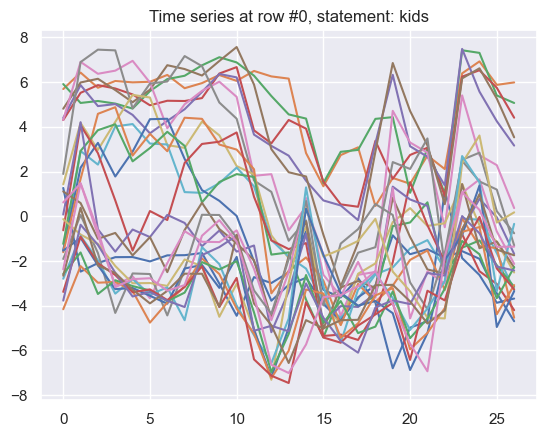

In [6]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

In [7]:
# sort by actors
sorted_indices = df['actor'].argsort()
df = df.iloc[sorted_indices].reset_index(drop=True)

traces = traces[sorted_indices]

traces

array([[[ 1.26500731,  5.68993118,  5.9124244 , ..., -3.7766364 ,
         -2.66279062, -2.37882361],
        [-2.47914302,  6.42696554,  5.06785043, ..., -0.38271389,
          0.37649934,  1.47306728],
        [-2.09884361,  5.74763755,  5.15509606, ..., -1.28364717,
         -2.20552429, -0.63863625],
        ...,
        [-2.63185789,  6.92692148,  7.30862121, ..., -0.76279143,
          0.98489513,  0.2818924 ],
        [-3.87456592,  5.87727676,  5.40423409, ..., -2.25553932,
         -1.49395756, -1.36999463],
        [-3.68517477,  5.98647473,  5.06738693, ..., -2.42848249,
         -1.74837971, -1.36252302]],

       [[-5.46933686, -2.29755139, -2.11689303, ..., -3.35699502,
         -2.49948089, -3.45376561],
        [-1.61183403, -4.28697198,  1.98656277, ..., -3.24523313,
         -3.97482995, -2.27460827],
        [-4.1269466 ,  0.62125114,  4.02175777, ..., -3.54327857,
         -2.58818872, -2.1367156 ],
        ...,
        [-3.92221362, -3.18245343,  4.29898858, ..., -

In [8]:
from sklearn.model_selection import train_test_split

split_index = df[df['actor'] == 'actor_19'].index[0]

X_train = traces[:split_index]
X_test = traces[split_index:]

y_train = df[TARGET][:split_index].to_numpy()
y_test = df[TARGET][split_index:].to_numpy()

X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

X_train_v.shape, X_valid.shape, X_test.shape, y_train_v.shape, y_valid.shape, y_test.shape

((1462, 27, 27), (366, 27, 27), (624, 27, 27), (1462,), (366,), (624,))

# CNN

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_train_v = label_encoder.transform(y_train_v)
y_valid = label_encoder.transform(y_valid)
y_test = label_encoder.transform(y_test)

In [10]:
def build_and_fit_cnn(X=X_train, y=y_train,
                      n_conv=0, n_hidden=0, hidden_nodes=32,
                      dropout=0, filters=8, kernel_size=5, batch_size=16):

    n_timesteps = X.shape[1]
    n_outputs = len(np.unique(y))
    n_features = X.shape[2]

    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(n_timesteps, n_features)
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(n_conv):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        if dropout:
            model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    for i in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, batch_size=batch_size, epochs=100, verbose=False)

    return model

In [11]:
import optuna
from keras.src.layers import BatchNormalization, Activation
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score

# objective function to be minimized
def objective_fun(trial):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 64)
    dropout = trial.suggest_int('dropout', 0, 1)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)

    cnn = build_and_fit_cnn(X=X_train_v,
                            y=y_train_v,
                            n_hidden=n_hidden,
                            hidden_nodes=hidden_nodes,
                            n_conv=n_conv,
                            dropout=dropout,
                            filters=filters,
                            kernel_size=kernel_size,
                            batch_size=batch_size)

    y_pred = np.argmax(cnn.predict(X_valid), axis=1)

    error = accuracy_score(y_valid, y_pred)

    return error


study = optuna.create_study(direction='maximize')
study.optimize(objective_fun, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-25 18:51:00,275] A new study created in memory with name: no-name-59f597d3-69a8-4e01-9780-8c770aa2d27e
[W 2023-06-25 18:51:00,385] Trial 6 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 11, 'dropout': 0, 'filters': 5, 'kernel_size': 15, 'batch_size': 62} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in conv1d_1. Consider increasing the input size. Received input shape [None, 13, 5] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/955614339.py", line 18, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/2518607590.py", 

12/12 [==============================] - 0s 2ms/step


[I 2023-06-25 18:51:11,317] Trial 3 finished with value: 0.5 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 38, 'dropout': 1, 'filters': 7, 'kernel_size': 11, 'batch_size': 59}. Best is trial 3 with value: 0.5.
[W 2023-06-25 18:51:11,356] Trial 11 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 14, 'dropout': 0, 'filters': 11, 'kernel_size': 16, 'batch_size': 42} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in conv1d_3. Consider increasing the input size. Received input shape [None, 12, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/955614339.py", line 18, in objective_fun
    cnn = build_

12/12 [==============================] - 0s 5ms/step


[I 2023-06-25 18:51:11,712] Trial 10 finished with value: 0.505464480874317 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 60, 'dropout': 0, 'filters': 13, 'kernel_size': 8, 'batch_size': 51}. Best is trial 10 with value: 0.505464480874317.
[W 2023-06-25 18:51:11,785] Trial 14 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 41, 'dropout': 1, 'filters': 5, 'kernel_size': 15, 'batch_size': 44} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in conv1d_6. Consider increasing the input size. Received input shape [None, 13, 5] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/955614339.py", line 18, in ob

12/12 [==============================] - 0s 2ms/step


[I 2023-06-25 18:51:14,499] Trial 5 finished with value: 0.4672131147540984 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 27, 'dropout': 1, 'filters': 9, 'kernel_size': 5, 'batch_size': 35}. Best is trial 10 with value: 0.505464480874317.


12/12 [==============================] - 0s 6ms/step


[I 2023-06-25 18:51:15,642] Trial 9 finished with value: 0.48360655737704916 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 18, 'dropout': 0, 'filters': 12, 'kernel_size': 3, 'batch_size': 39}. Best is trial 10 with value: 0.505464480874317.
[W 2023-06-25 18:51:15,678] Trial 17 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 54, 'dropout': 1, 'filters': 10, 'kernel_size': 16, 'batch_size': 53} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in conv1d_5. Consider increasing the input size. Received input shape [None, 12, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/955614339.py", line 18, in

12/12 [==============================] - 0s 4ms/step


[I 2023-06-25 18:51:16,321] Trial 1 finished with value: 0.45901639344262296 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 27, 'dropout': 1, 'filters': 7, 'kernel_size': 6, 'batch_size': 49}. Best is trial 10 with value: 0.505464480874317.


12/12 [==============================] - 0s 3ms/step


[I 2023-06-25 18:51:17,544] Trial 0 finished with value: 0.4808743169398907 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 59, 'dropout': 1, 'filters': 14, 'kernel_size': 9, 'batch_size': 56}. Best is trial 10 with value: 0.505464480874317.


12/12 [==============================] - 0s 2ms/step


[I 2023-06-25 18:51:21,735] Trial 8 finished with value: 0.45901639344262296 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 14, 'dropout': 0, 'filters': 10, 'kernel_size': 10, 'batch_size': 21}. Best is trial 10 with value: 0.505464480874317.


12/12 [==============================] - 0s 2ms/step


[I 2023-06-25 18:51:22,938] Trial 15 finished with value: 0.505464480874317 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 28, 'dropout': 0, 'filters': 6, 'kernel_size': 3, 'batch_size': 44}. Best is trial 10 with value: 0.505464480874317.
[W 2023-06-25 18:51:22,999] Trial 22 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 61, 'dropout': 1, 'filters': 10, 'kernel_size': 15, 'batch_size': 20} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in conv1d_9. Consider increasing the input size. Received input shape [None, 13, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/955614339.py", line 18, in o

12/12 [==============================] - 0s 3ms/step


[I 2023-06-25 18:51:23,274] Trial 13 finished with value: 0.5 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 14, 'dropout': 0, 'filters': 5, 'kernel_size': 5, 'batch_size': 44}. Best is trial 10 with value: 0.505464480874317.


12/12 [==============================] - 0s 8ms/step


[I 2023-06-25 18:51:24,061] Trial 2 finished with value: 0.5109289617486339 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 63, 'dropout': 0, 'filters': 3, 'kernel_size': 5, 'batch_size': 22}. Best is trial 2 with value: 0.5109289617486339.
[W 2023-06-25 18:51:24,602] Trial 25 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 48, 'dropout': 0, 'filters': 2, 'kernel_size': 16, 'batch_size': 18} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in conv1d_3. Consider increasing the input size. Received input shape [None, 12, 2] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/955614339.py", line 18, in obj

12/12 [==============================] - 0s 2ms/step


[I 2023-06-25 18:51:31,285] Trial 19 finished with value: 0.5 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 36, 'dropout': 0, 'filters': 8, 'kernel_size': 2, 'batch_size': 37}. Best is trial 2 with value: 0.5109289617486339.
[W 2023-06-25 18:51:31,374] Trial 50 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 58, 'dropout': 0, 'filters': 3, 'kernel_size': 16, 'batch_size': 17} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in conv1d_6. Consider increasing the input size. Received input shape [None, 12, 3] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/955614339.py", line 18, in objective_fun
   

12/12 [==============================] - 0s 4ms/step


[W 2023-06-25 18:51:33,289] Trial 68 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 64, 'dropout': 0, 'filters': 2, 'kernel_size': 8, 'batch_size': 16} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in conv1d_47. Consider increasing the input size. Received input shape [None, 6, 2] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/955614339.py", line 18, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/2518607590.py", line 20, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
 

12/12 [==============================] - 0s 4ms/step


[W 2023-06-25 18:51:36,567] Trial 113 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 64, 'dropout': 0, 'filters': 2, 'kernel_size': 16, 'batch_size': 16} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in conv1d_60. Consider increasing the input size. Received input shape [None, 12, 2] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/955614339.py", line 18, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_45829/2518607590.py", line 20, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')

12/12 [==============================] - 0s 1ms/step


[I 2023-06-25 18:51:39,221] Trial 20 finished with value: 0.48360655737704916 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 19, 'dropout': 1, 'filters': 9, 'kernel_size': 3, 'batch_size': 24}. Best is trial 2 with value: 0.5109289617486339.


12/12 [==============================] - 0s 3ms/step


[I 2023-06-25 18:51:40,742] Trial 21 finished with value: 0.505464480874317 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 48, 'dropout': 1, 'filters': 10, 'kernel_size': 8, 'batch_size': 35}. Best is trial 2 with value: 0.5109289617486339.


12/12 [==============================] - 0s 1ms/step


[I 2023-06-25 18:51:40,766] Trial 16 finished with value: 0.48360655737704916 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 34, 'dropout': 0, 'filters': 3, 'kernel_size': 7, 'batch_size': 22}. Best is trial 2 with value: 0.5109289617486339.


12/12 [==============================] - 0s 600us/step


[I 2023-06-25 18:51:43,758] Trial 49 finished with value: 0.505464480874317 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 48, 'dropout': 0, 'filters': 3, 'kernel_size': 14, 'batch_size': 17}. Best is trial 2 with value: 0.5109289617486339.


12/12 [==============================] - 0s 530us/step


[I 2023-06-25 18:51:44,662] Trial 23 finished with value: 0.4890710382513661 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 48, 'dropout': 0, 'filters': 9, 'kernel_size': 2, 'batch_size': 16}. Best is trial 2 with value: 0.5109289617486339.


In [12]:
best_params = study.best_params
best_params

{'n_conv': 1,
 'n_hidden': 1,
 'hidden_nodes': 63,
 'dropout': 0,
 'filters': 3,
 'kernel_size': 5,
 'batch_size': 22}

In [13]:
cnn = build_and_fit_cnn(**best_params)
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 3)             408       
                                                                 
 batch_normalization (Batch  (None, 23, 3)             12        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 23, 3)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 3)             48        
                                                                 
 batch_normalization_1 (Bat  (None, 19, 3)             12        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 19, 3)             0

In [14]:
from sklearn.metrics import f1_score, classification_report

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 538us/step
Accuracy 0.47275641025641024
F1-score [0.5140325  0.42381786]
              precision    recall  f1-score   support

           0       0.48      0.56      0.51       312
           1       0.47      0.39      0.42       312

    accuracy                           0.47       624
   macro avg       0.47      0.47      0.47       624
weighted avg       0.47      0.47      0.47       624

